## Entrenamiento completo
Hemos visto los diferentes componentes y pre requisitos de código para comenzar a entrenar nuestras redes neuronales. Ahora pondremos todos los aspectos juntos. El entrenamiento de un modelo es un proceso iterativo. En cada iteración se debe seguir los siguientes pasos:

1. Recolectar muestras
2. hacer una predicción
3. calcular el error de la predicción (loss)
4. calcular la gradiente del error con respecto de los parámetros
5. modificar los parámetros de acuerdo a un criterio de **optimización**


In [1]:
# codigo visto previamente
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor



## Carga del dataset

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

## Definición del modelo de la red neuronal

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Hiperparámetros

Los hiperparámetros son parámetros ajustables que nos permiten controlar el proceso de optimización y entrenamiento del modelo. La variación en los valores de los hiperparámetros impactan en el entrenamiento y los radios de convergencia. Definiremos los siguientes hiperparámetros para este ejemplo:

- Número de Épocas: El número de veces de iterar sobre todo el dataset de entrenamiento.
- Batch Size: Tamaño del minilote. El número de muestras propagadas a través de la red antes de ser actualizados los parámetros de la red.
- Learning Rate: Un parámetro de cantidad de variación de parámetros en cada lote/época. Valores pequeños hacen un entrenamiento lento, valores muy grandes pueden hacer el entrenamiento inestable.

In [5]:
learning_rate = 1e-3
batch_size = 64
epochs = 20

# Bucle de optimización

Una vez tenemos los dataset, definición del modelo y los hiperparámetros, podemos proceder a correr el bucle de entrenamiento. Cada iteración del bucle se conoce como Época. En cada época realizamos 2 procesos:

1. Train Loop: El bucle de entrenamiento y optimización de los parámetros de la red (Backpropagation).
2. Validation/Test Loop: Bucle para recolectar métricas de rendimiento durante el entrenamiento del modelo.

### Función de costo
Las funciones de costo miden el grado de similitud entre las predicciones de la red y los resultados esperados. La idea principal del entrenamiento de una red es minimizar la función de costo. 

Pytorch incluye implementaciones de funciones de costo comunes como MSE, NLL, CrossEntropy y otros.

In [6]:
loss_fn = nn.CrossEntropyLoss()

### Optimizador
La optimizaci'on es el proceso de ajustar los parámetros del modelo para reducir el error en cada paso de entrenamiento. Los algoritmos de optimización u Optimizadores definen la forma en la que este proceso es realizado. Toda la lógica de optimización esta encapsulada en el objeto `optimizer`. 

Pytorch también incluye implementaciones de optimizadores populares como ADAM, RMSProp, SGD y otros.

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Implemetanción completa

In [8]:
# bucle de entrenamiento

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # modo entrenamiento
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward
        # prediccion y costo
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# funcion de pruebas
def test_loop(dataloader, model, loss_fn):
    # modo evaluacion
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # evaluacion del modelo con torch.no_grad
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [9]:
# bucle principal
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296644  [   64/60000]
loss: 2.294691  [ 6464/60000]
loss: 2.296392  [12864/60000]
loss: 2.295469  [19264/60000]
loss: 2.268817  [25664/60000]
loss: 2.278042  [32064/60000]
loss: 2.257209  [38464/60000]
loss: 2.257734  [44864/60000]
loss: 2.254632  [51264/60000]
loss: 2.227723  [57664/60000]
Test Error: 
 Accuracy: 40.4%, Avg loss: 2.235202 

Epoch 2
-------------------------------
loss: 2.234735  [   64/60000]
loss: 2.230986  [ 6464/60000]
loss: 2.213732  [12864/60000]
loss: 2.215876  [19264/60000]
loss: 2.180975  [25664/60000]
loss: 2.162709  [32064/60000]
loss: 2.143963  [38464/60000]
loss: 2.119002  [44864/60000]
loss: 2.113693  [51264/60000]
loss: 2.058961  [57664/60000]
Test Error: 
 Accuracy: 52.0%, Avg loss: 2.066788 

Epoch 3
-------------------------------
loss: 2.075653  [   64/60000]
loss: 2.059819  [ 6464/60000]
loss: 1.996986  [12864/60000]
loss: 2.011324  [19264/60000]
loss: 1.935339  [25664/60000]
loss: 1.885598  [32064/600

In [10]:
import matplotlib.pyplot as plt

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


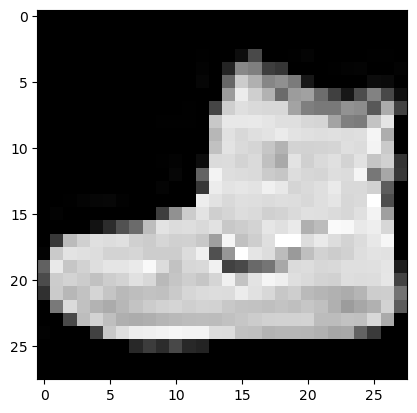

Label: 9


In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")